# A Comparison of Neighborhood-Based and Latent Factor-Based Collaborative Filtering for Music Recommendation

We compare three approaches of recomending music. Each approaches is trained from the same data. This data is implicit feedback collected from users listenting to music. From m users and n songs, we create an m x n matrix where each cell is how many times user u listened to song i. We call an entry in this an interaction matrix and entry in it a rating or r_ui.

In [1]:
import math
import random
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [2]:
# Use pandas to create our interaction matrix (represented as a dataframe)
def create_interaction_dataframe(df, user_col, item_col, r_col):
    sums = df.groupby([user_col, item_col])[r_col].sum()
    return sums.unstack().reset_index().fillna(0).set_index(user_col)

# Create a matrix with all preferences
def create_pref_matrix(matrix):
    pref_matrix = np.copy(matrix)
    for u in range(matrix.shape[0]):
        for i in range(matrix.shape[1]):
            if (matrix[u, i] > 0):
                pref_matrix[u, i] = 1
    return pref_matrix

# Create a matrix with all confidence values
def create_conf_matrix(matrix, alpha):
    conf_matrix = np.copy(matrix)
    for u in range(matrix.shape[0]):
        for i in range(matrix.shape[1]):
            conf_matrix[u, i] = 1 + (alpha * matrix[u, i])
    return conf_matrix

# Is a vector all zeros?
def is_zero(vec):
    return not np.any(vec)

# Flip of coin with some probability of heads
def coin_flip(probability):
    return random.random() < probability

# Hide some fraction of non-zero listen counts
def mask(matrix, fraction):
    masked_users = set([])
    for u in range(matrix.shape[0]):
        for i in range(matrix.shape[1]):
            if (matrix[u, i] > 0 and coin_flip(fraction)):
                matrix[u, i] = 0
                # We want to avoid having an item or user be the zero
                # vector because then we cannot do cosine similiarity.
                if (is_zero(matrix[u]) or is_zero(matrix[:, i])):
                    matrix[u, i] = 1
                    continue
                masked_users.add(u)
    return masked_users

# Seed our RNGs with 0
random.seed(0)
np.random.seed(0)

# Read in the data as (user, song, listen_count) triplets
triplets = pd.read_table('train_triplets_small.txt', header=None)
triplets.columns = ['user_id', 'song_id', 'listen_count']

# Truncate to workable size
triplets = triplets.truncate(before=0, after=3000)

# Hyperparameters
f = 20  # Number of latent factors
a = 140 # Weight for confidence (alpha)
l = 0.5 # Weight for regularization (lambda)

# Create the interaction matrix
interaction_dataframe = create_interaction_dataframe(triplets, 'user_id', 'song_id', 'listen_count')
matrix = np.array(interaction_dataframe)

# Constants (These are the varibles the Hu paper users.)
n = matrix.shape[1] # Number of items
m = matrix.shape[0] # Number of users

# Our test data is just the unaltered matrix
test_matrix = np.copy(matrix)
test_pref_matrix = create_pref_matrix(test_matrix)
test_conf_matrix = create_conf_matrix(test_matrix, a)

# Our training data is the interaction matrix with 20% of positive interactions hidden
train_matrix = np.copy(matrix)
masked_users = mask(train_matrix, 0.20)
train_pref_matrix = create_pref_matrix(train_matrix)
train_conf_matrix = create_conf_matrix(train_matrix, a)

## Methods

We look at three methods.

### Neighborhood Model

Our neighborhood model is based on calculating the similiarity of users. Essentially, for each r_ui we want to predict, we find u's k closets neighbors. We do this by calculating the cosine similiarity of the users' item vectors. Then we find the weighted average of what those k neighbors rated song u. We call this weighted average r_ui. Their rating is simply their listen count. We calculate r_u_i for every user-item pair.

In [3]:
# Create a m x m matrix with user cosine distances
def create_user_dist_matrix(train_matrix):
    user_dist_matrix = np.empty((m, m))
    for u in range(m):
        for w in range(m):
            user_dist_matrix[u, w] = cosine(train_matrix[u], train_matrix[w])
    return user_dist_matrix

# Get the k nearest users to a given user index
def nearest_users(user_dist_matrix, k, u):
    # Skip the first which will always be the user u itself
    return np.argsort(user_dist_matrix[u])[1:k + 1]

# Predict the rating (listen count) of a item given by a user by using
# the nearest users.
def predict_rating_by_user(user_dist_matrix, k, u, i):
    top_sum, bot_sum = 0, 0
    for w in nearest_users(user_dist_matrix, k, u):
        top_sum += user_dist_matrix[u, w] * train_matrix[w, i]
        bot_sum += abs(user_dist_matrix[u, w])
    return top_sum / math.sqrt(bot_sum)

# Create a n x m matrix with every users predicted ratings by using
# the nearest users.
def predict_by_user(train_matrix, k):
    user_dist_matrix = create_user_dist_matrix(train_matrix)
    predictions = np.zeros((m, n))
    for u in range(m):
        for i in range(n):
            predictions[u, i] = predict_rating_by_user(user_dist_matrix, k, u, i)
    return predictions

In [4]:
nn_predictions = predict_by_user(train_matrix, 3)

### Latent Factor Model

You may have noticed that a user's listen count for a song is not really a rating. If a user has never listened to a sing (a listen count of 0), that does not mean they do not like it. They simply may have never heard it. Additionally, from our data we have no way to tell if a user does not like a song. We make two assumptions: (1) if a user listened to a song once, they like it, (2) they more a user listened to a song, the more they like it. This is reflected in our two derived values. Preference, p_ui, is a binary value denoting if a user has ever listend to a song. Confidence, c_ui, is a scalar-weighted value proportional to listen count. Confidence denotes how confident we are they like the song.

A latent factor model attempts to find "latent" or hidden features for users and songs from the interaction matrix.

In [5]:
# Recalcate the user factors X entirly using item factors Y
def recalc_user_factors(X, Y, pref_matrix, conf_matrix, l):
    Y_T = np.transpose(Y)
    Y_T_Y = np.matmul(Y_T, Y)
    for u in range(m):
        Cu = np.diag(conf_matrix[u])
        Y_T_Cu_p = np.matmul(Y_T, np.matmul(Cu, pref_matrix[u]))
        temp = np.matmul(Y_T, np.matmul(Cu - np.identity(n), Y))
        temp = np.linalg.inv(Y_T_Y + temp + l * np.identity(f))
        X[u] = np.matmul(temp, Y_T_Cu_p)

# Recalcate the item factors Y entirly using user factors X
def recalc_item_factors(X, Y, pref_matrix, conf_matrix, l):
    X_T = np.transpose(X)
    X_T_X = np.matmul(X_T, X)
    for i in range(n):
        Ci = np.diag(conf_matrix[:, i])
        X_T_Ci_p = np.matmul(X_T, np.matmul(Ci, pref_matrix[:, i]))
        temp = np.matmul(X_T, np.matmul(Ci - np.identity(m), X))
        temp = np.linalg.inv(X_T_X + temp + l * np.identity(f))
        Y[i] = np.matmul(temp, X_T_Ci_p)

# Alternating least squares optimization
def als(X, Y, pref_matrix, conf_matrix, l, sweeps):
    for _ in range(sweeps):
        recalc_user_factors(X, Y, pref_matrix, conf_matrix, l)
        recalc_item_factors(X, Y, pref_matrix, conf_matrix, l)

# Create a matrix of real-value predictions
def predict_by_latent_factors(X, Y):
    predictions = np.zeros((m, n))
    for u in range(m):
        for i in range(n):
            predictions[u, i] = np.matmul(np.transpose(X[u]), Y[i])
    return predictions

In [6]:
# Create the (initially) random latent factor matrices
X = np.random.rand(m, f) # users-factors
Y = np.random.rand(n, f) # items-factors

# Train using Alternating Least Squares
als(X, Y, train_pref_matrix, train_conf_matrix, l, 10)

# Make our predictions using these latent factors
latent_predictions = predict_by_latent_factors(X, Y)

### Popularity

What if we just predict a user's ranking of a song based entirly on how popularity of the song? This is a suprisingly hard model to beat.

In [7]:
def predict_by_popularity(matrix):
    num_songs = matrix.shape[1]
    # Contains song indices in order of popularity.
    # Later in the list -> more popular
    popular = np.argsort(np.sum(matrix, axis=0))
    popularity_matrix = np.zeros((m, n))
    for i in range(n):
        position = np.argwhere(popular == i)[0, 0]
        percentile = (position + 1) / num_songs
        for u in range(m):
              popularity_matrix[u, i] = percentile
    return popularity_matrix

pop_predictions = predict_by_popularity(matrix)

## Evaluation

This is a binary classification problem where we are attempting to predict if user "prefers" a song given an arbitrary user-song pair. Each approach gives a real value prediction and we use a ROC curve for each user's predictions to understand the threshold for mapping this real value to a binary 1 or 0. Our final evaluation for the success of the model is the mean area under the curve (AUC) of the ROC curve for each user.

In [26]:
def mean_auc(pref_matrix, predictions, masked_users):
    aucs = []
    for u in masked_users:
        fpr, tpr, _ = metrics.roc_curve(pref_matrix[u], predictions[u])
        aucs.append(metrics.auc(fpr, tpr))
    return np.mean(aucs)

def plot_roc(actual, predicted, title):
    fpr, tpr, _ = metrics.roc_curve(actual, predicted)
    auc = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC Curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

Mean AUC (Neighborhood): 0.584695042271343
Mean AUC (Latent Model): 0.9681248924909588
Mean AUC (Popular):      0.6112951213138439




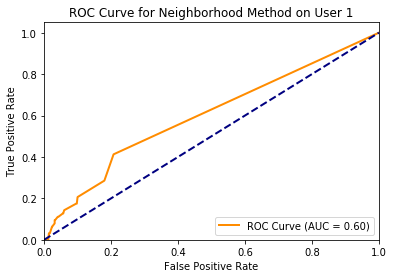

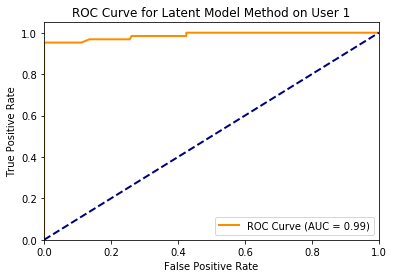

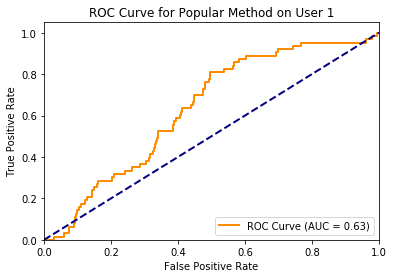

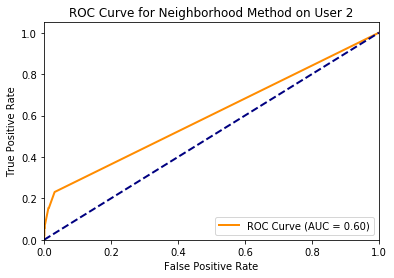

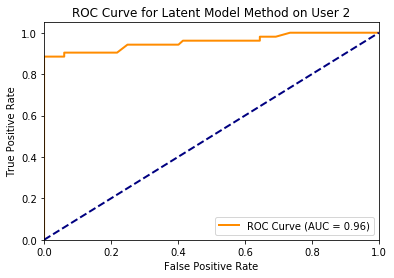

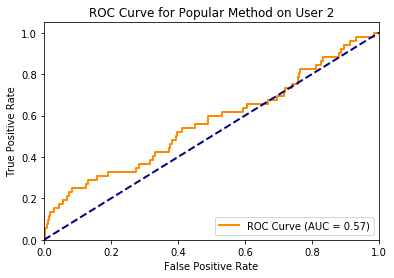

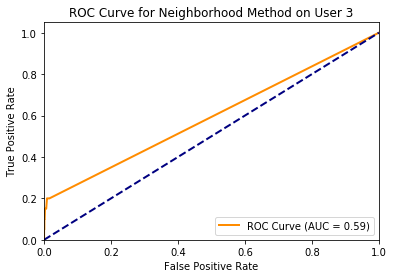

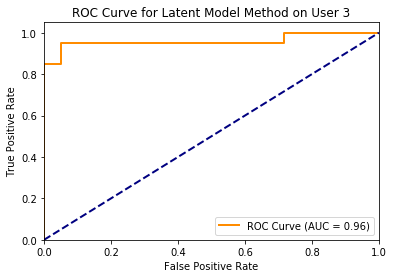

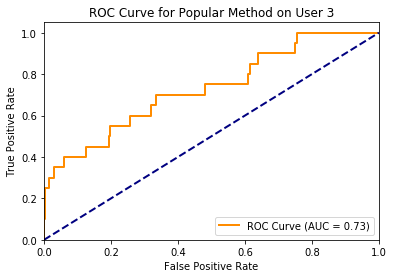

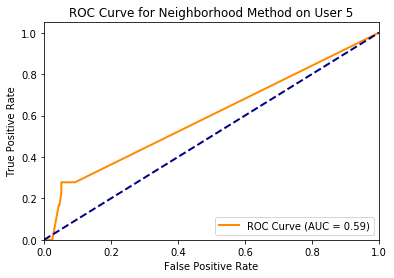

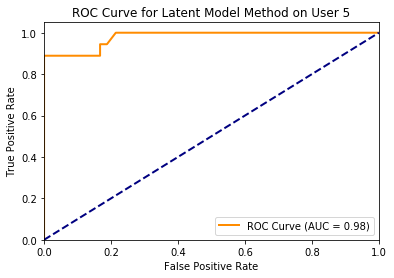

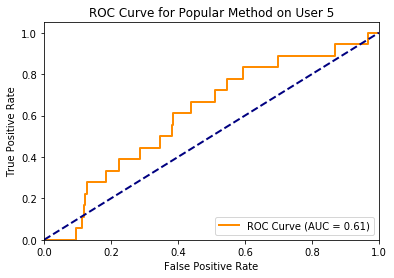

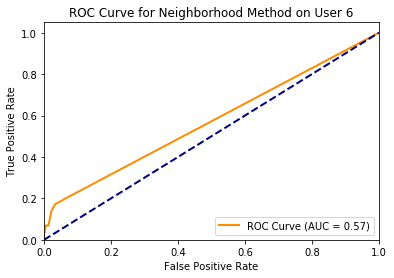

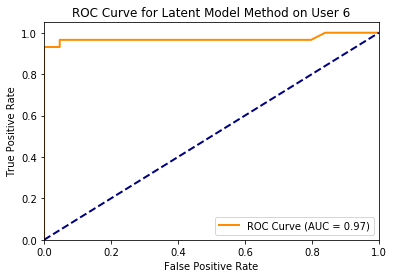

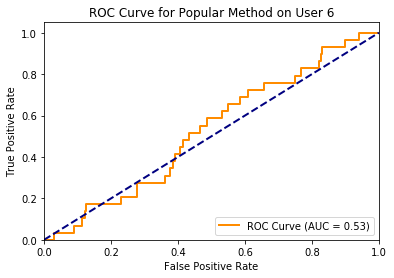

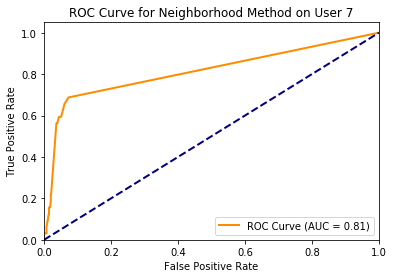

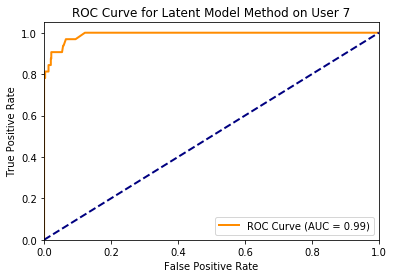

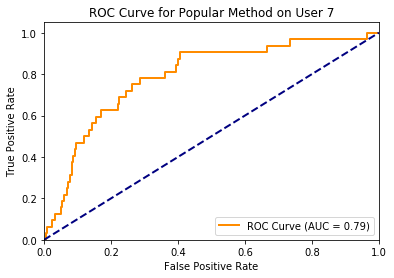

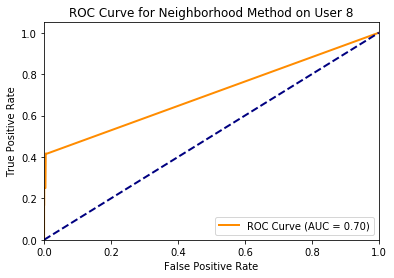

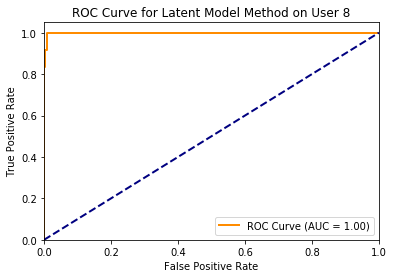

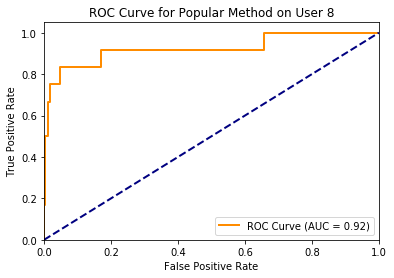

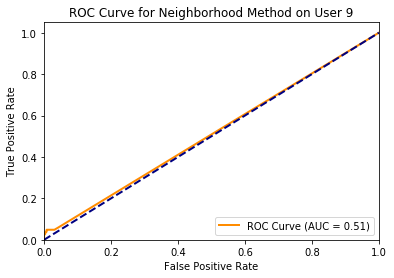

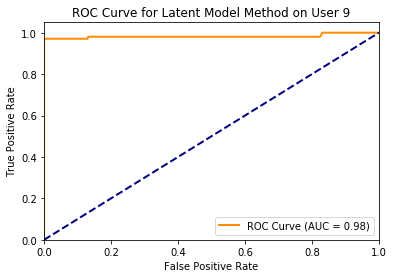

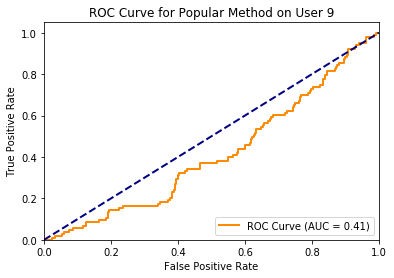

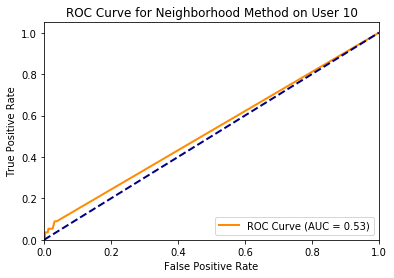

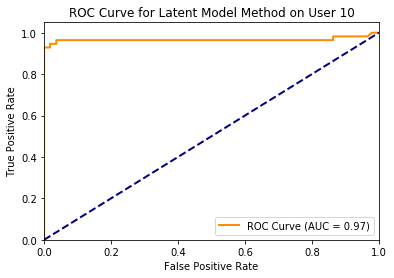

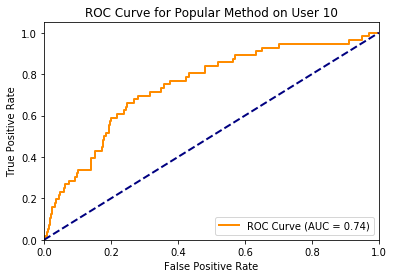

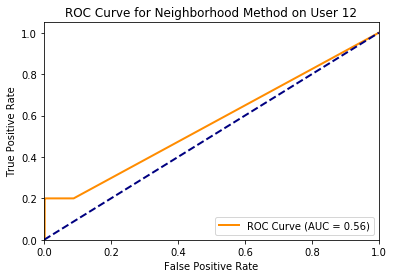

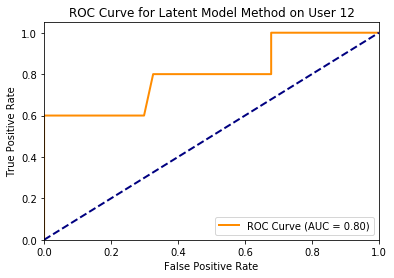

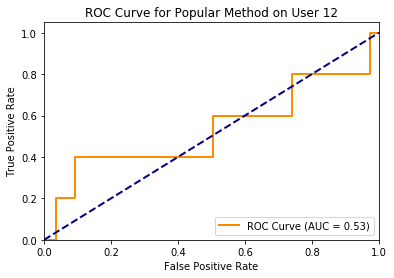

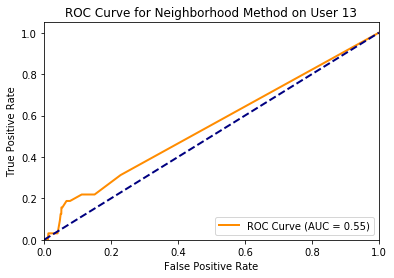

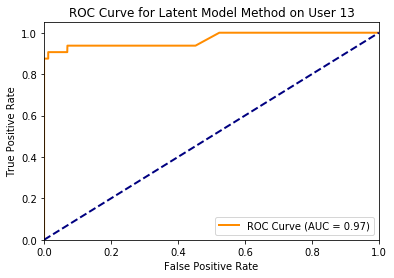

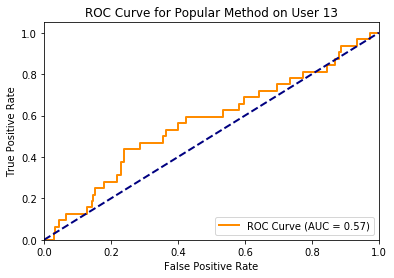

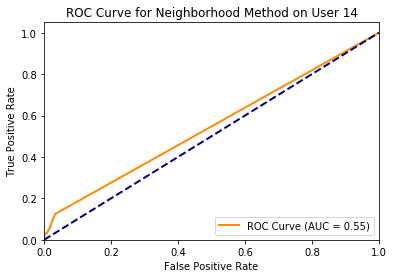

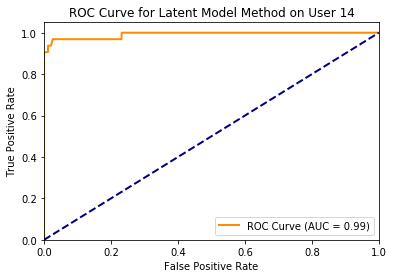

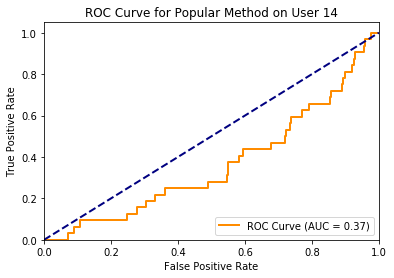

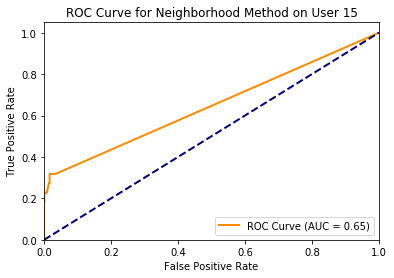

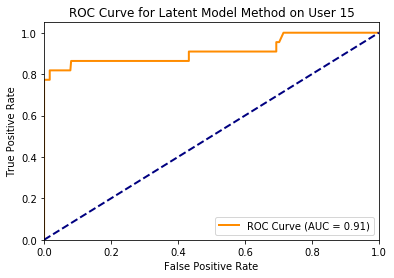

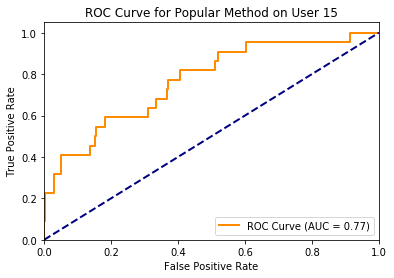

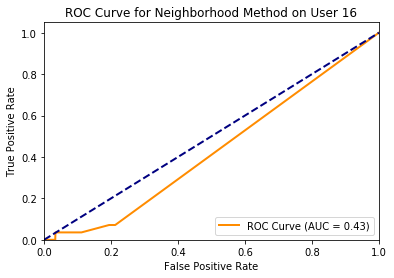

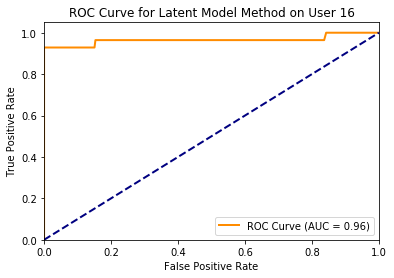

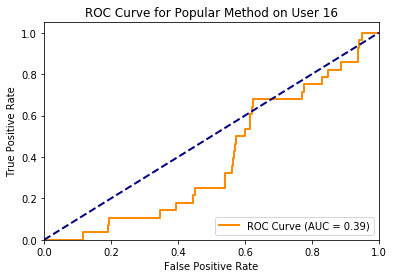

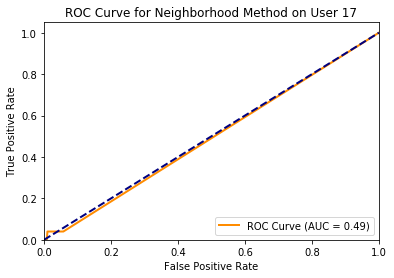

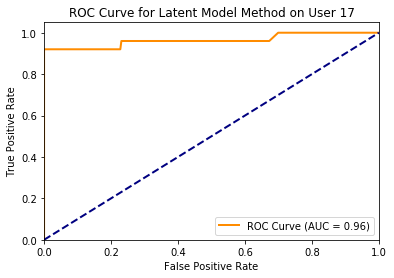

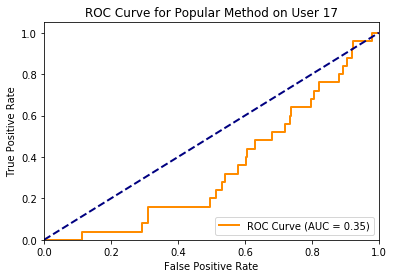

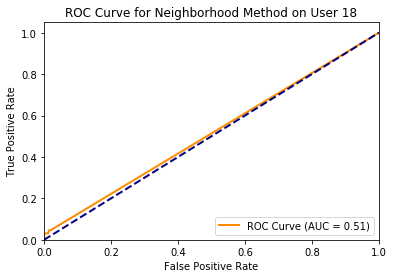

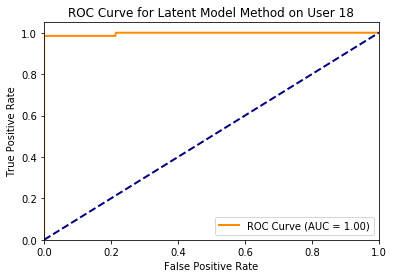

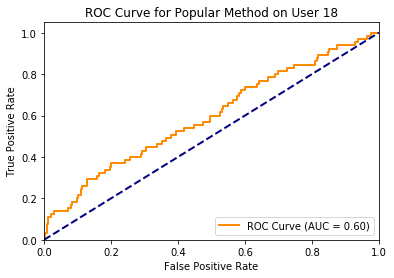

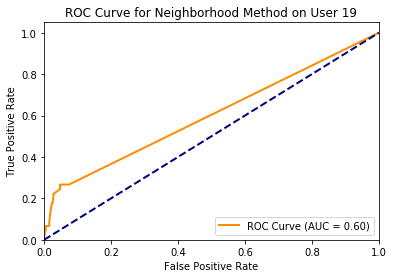

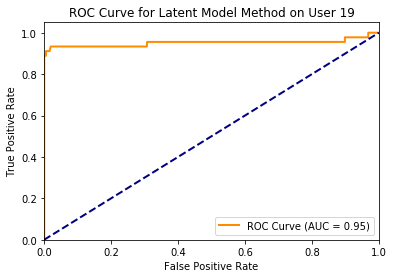

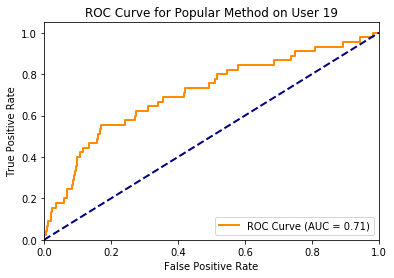

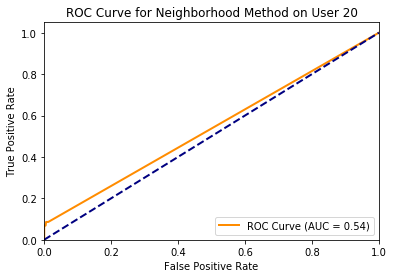

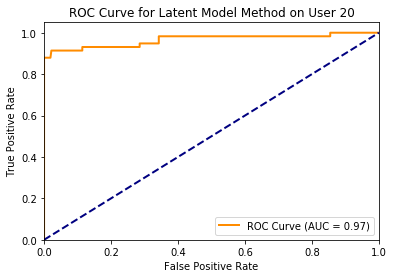

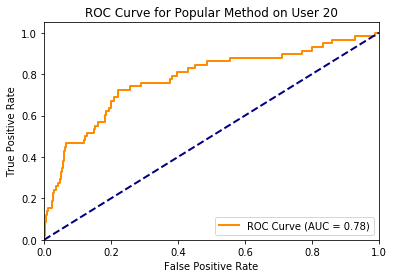

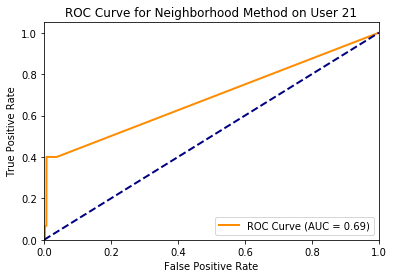

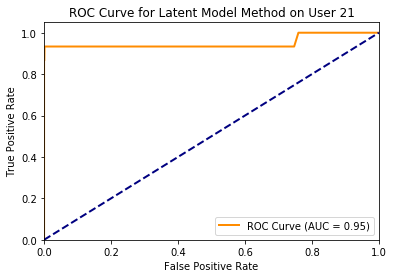

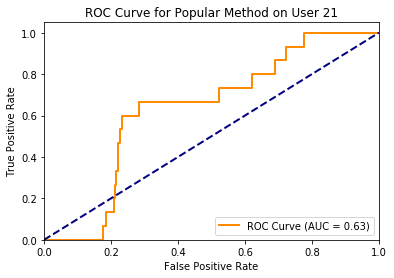

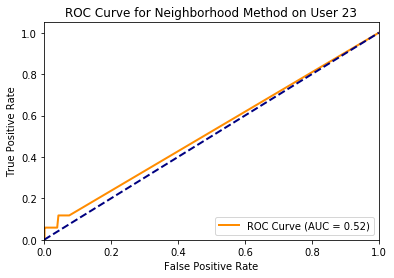

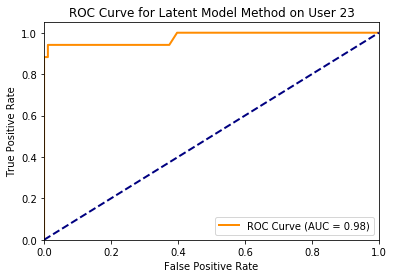

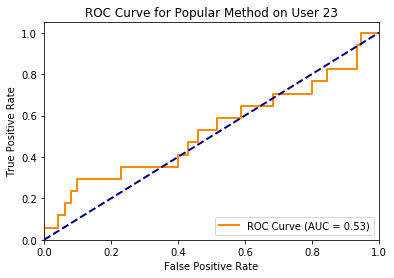

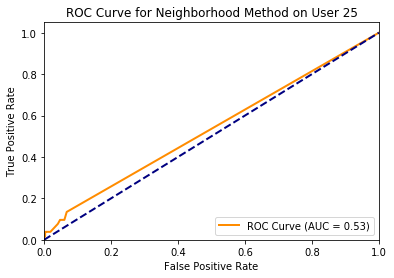

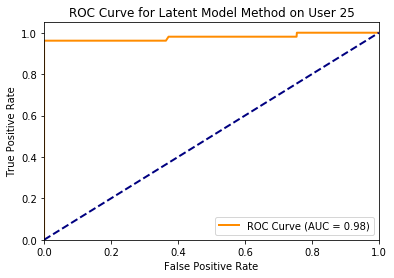

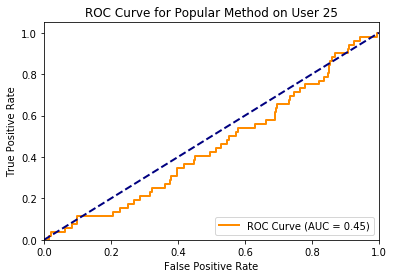

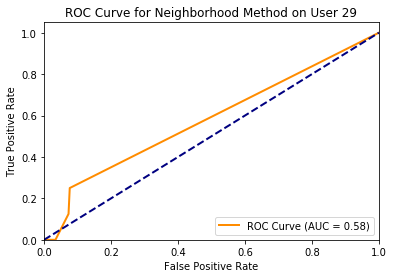

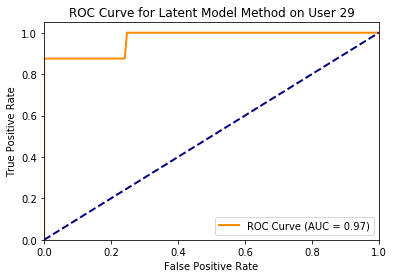

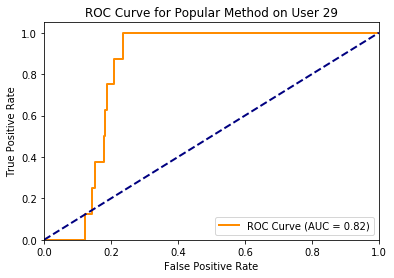

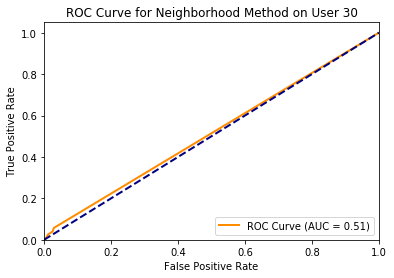

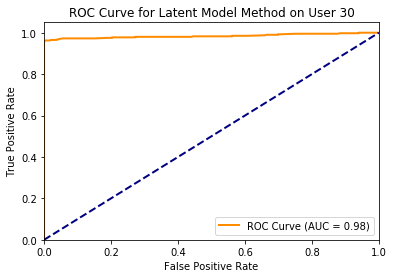

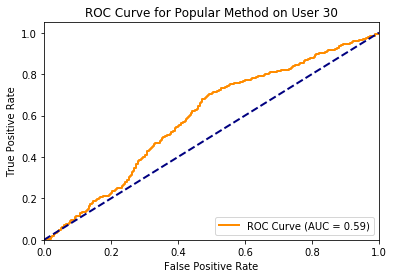

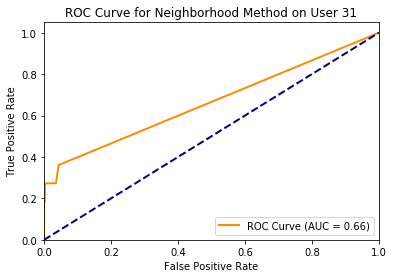

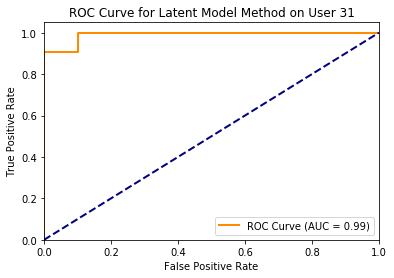

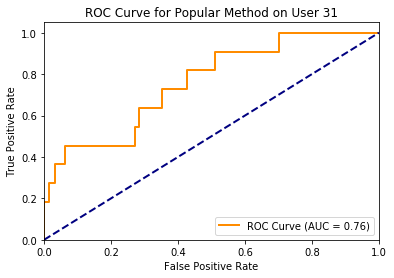

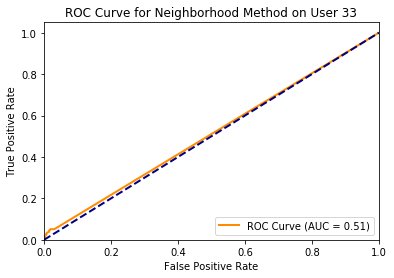

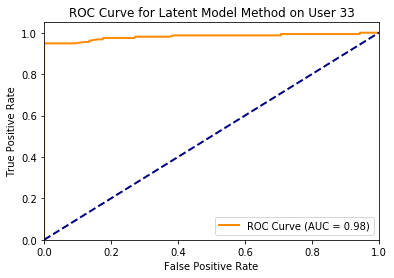

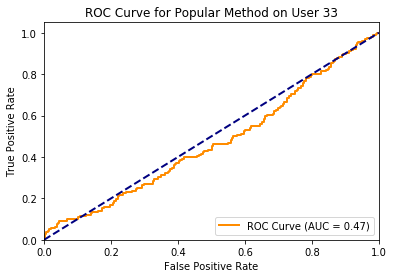

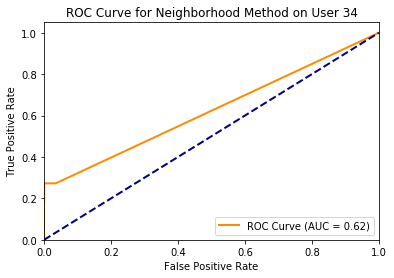

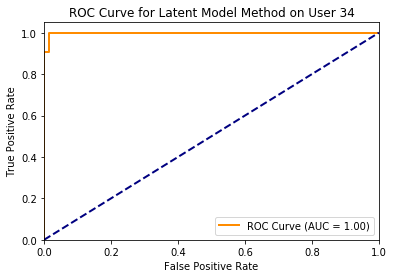

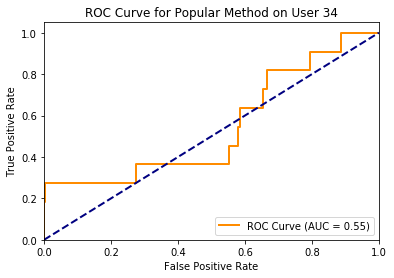

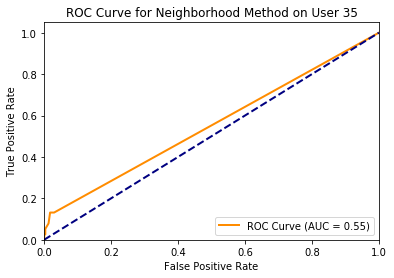

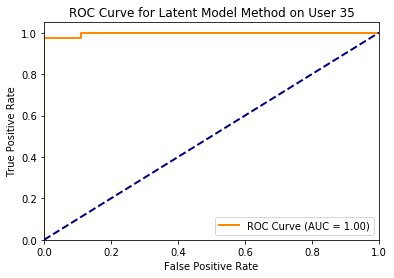

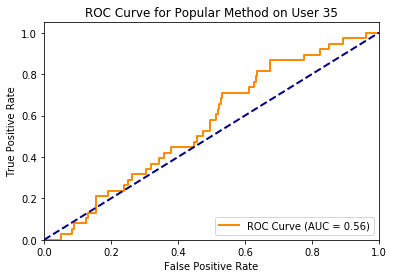

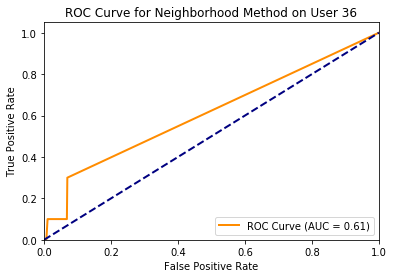

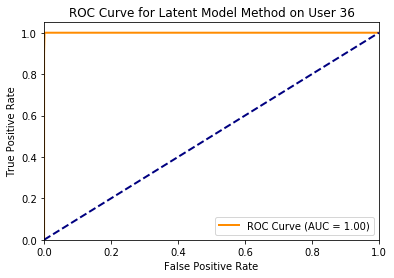

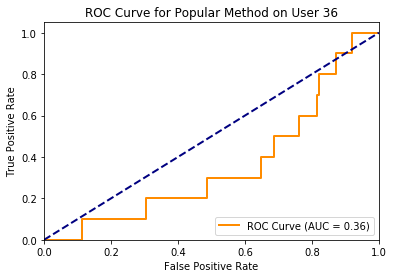

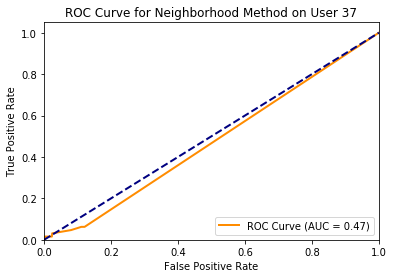

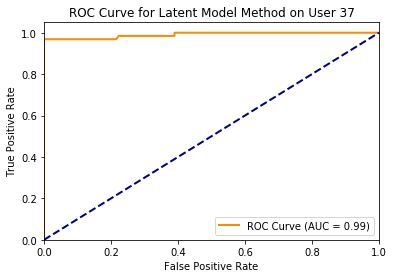

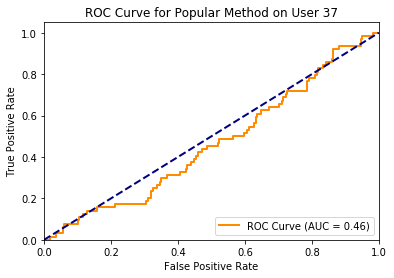

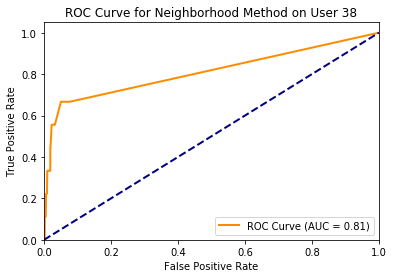

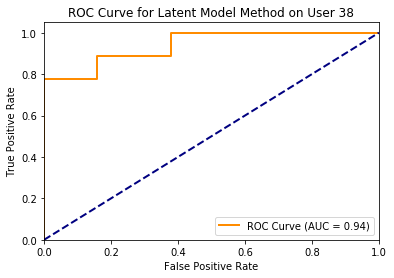

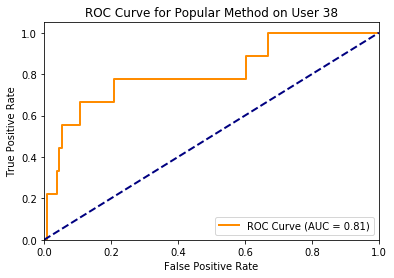

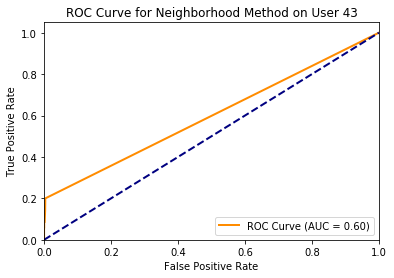

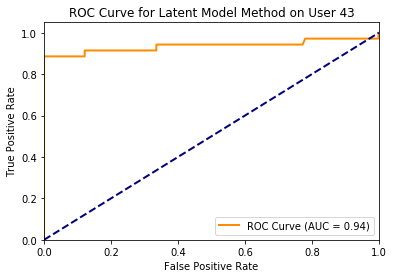

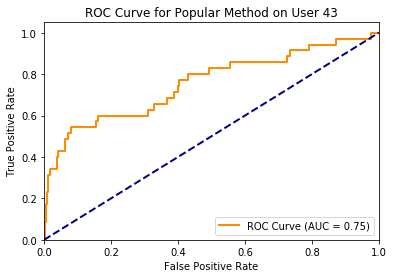

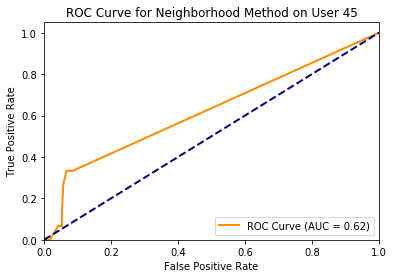

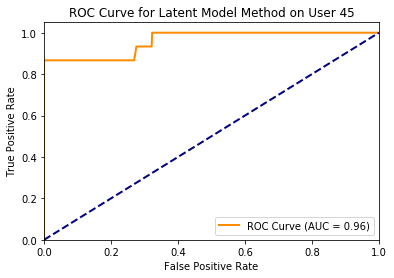

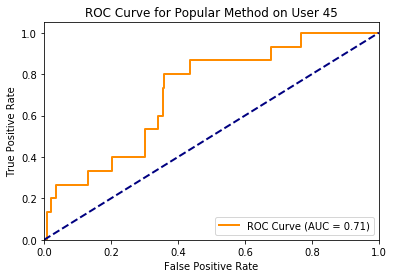

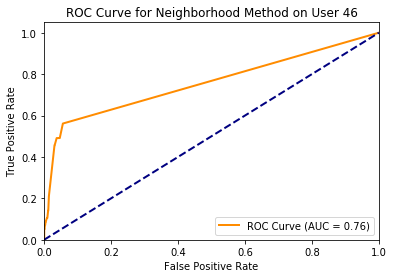

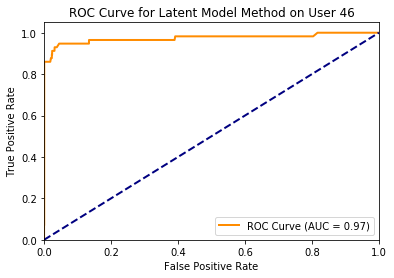

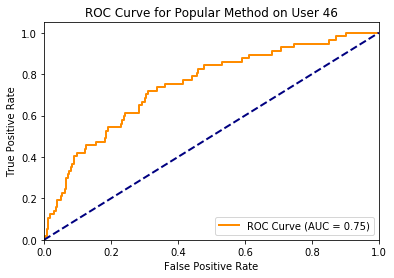

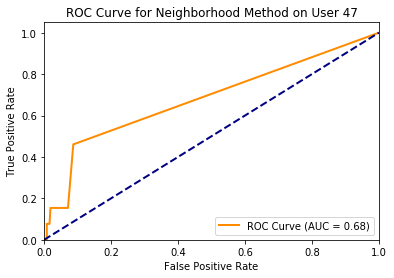

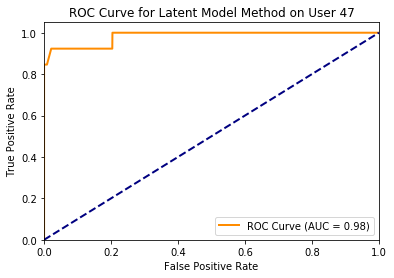

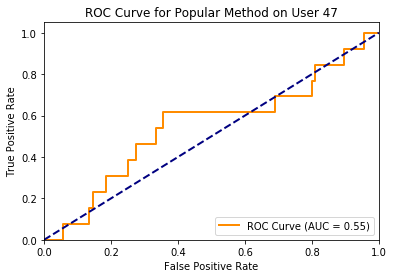

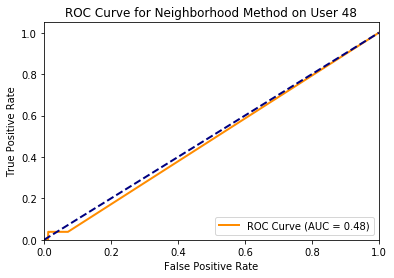

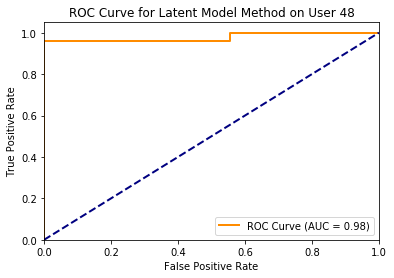

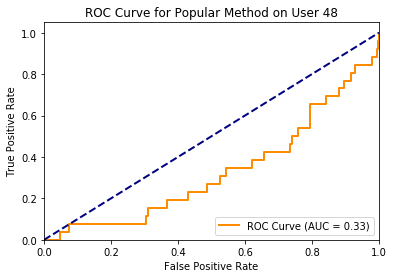

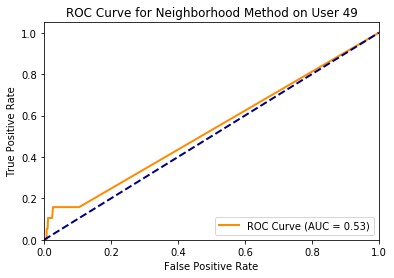

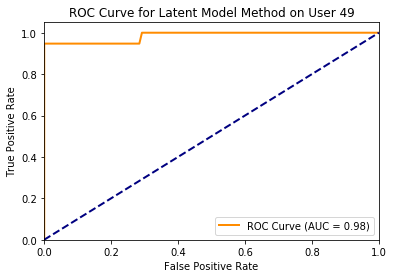

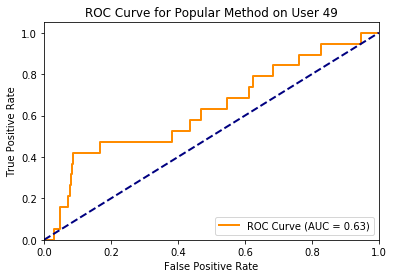

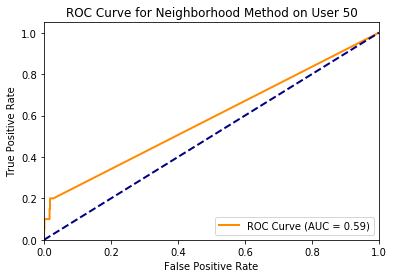

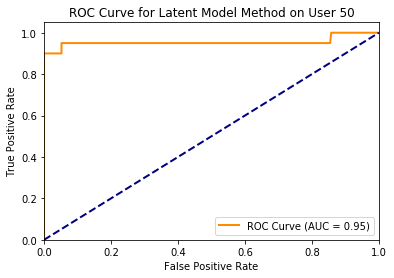

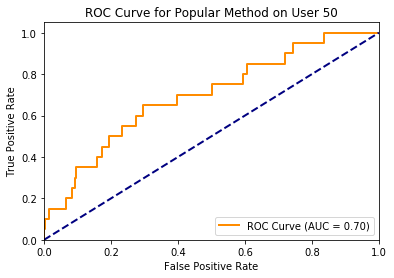

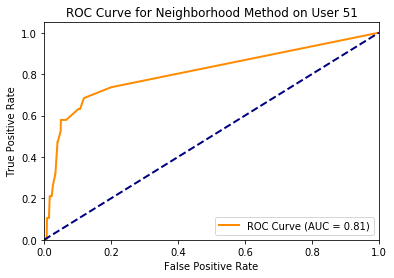

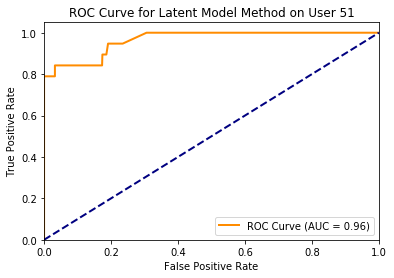

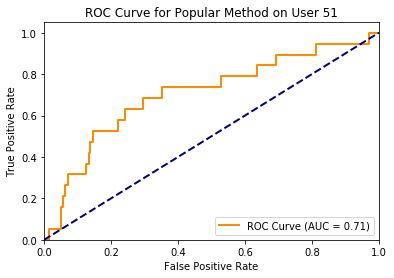

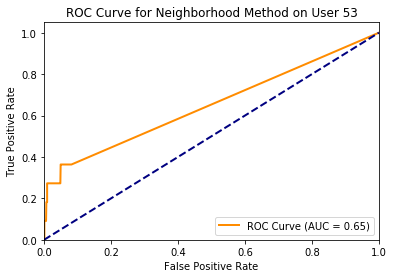

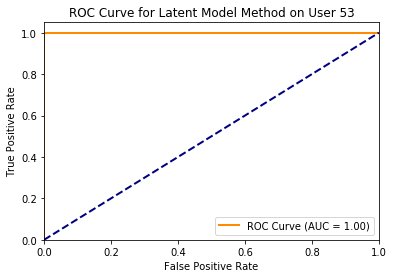

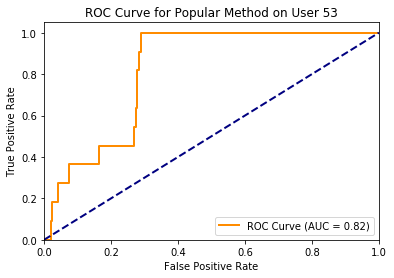

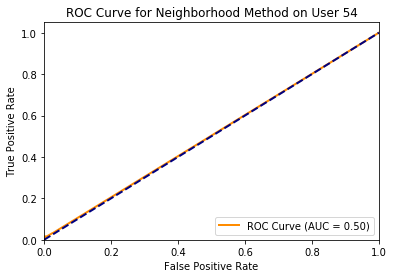

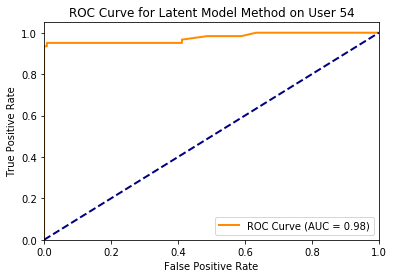

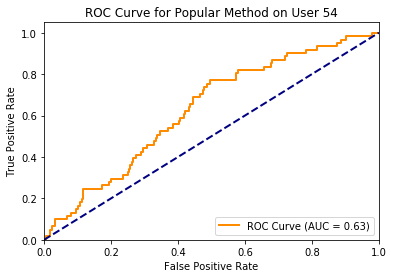

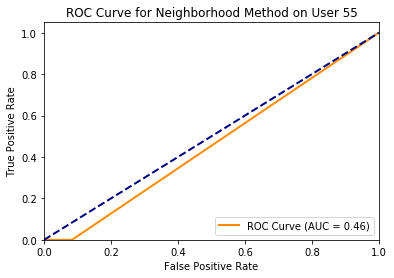

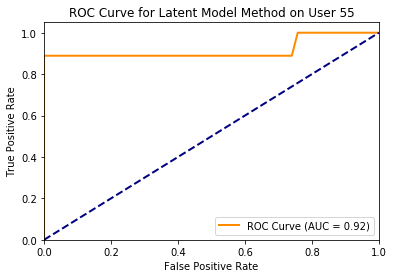

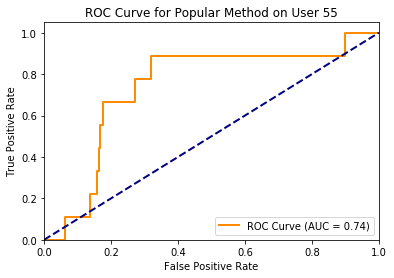

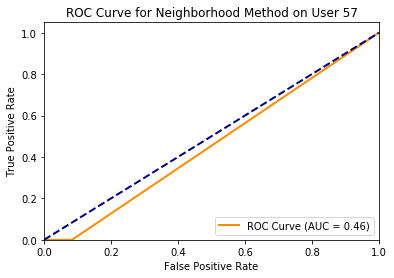

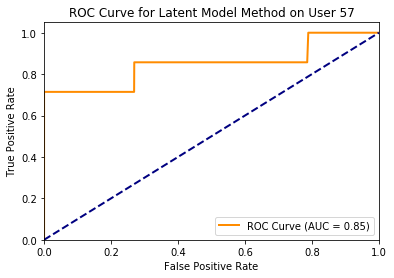

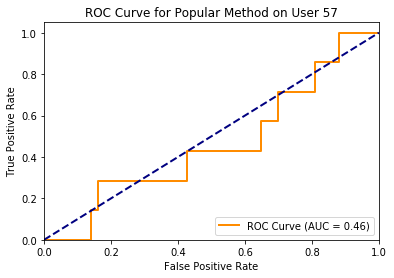

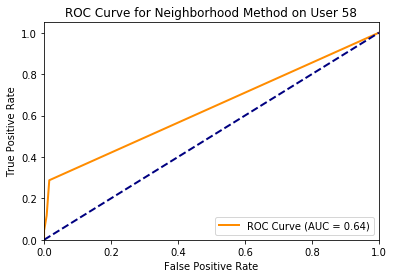

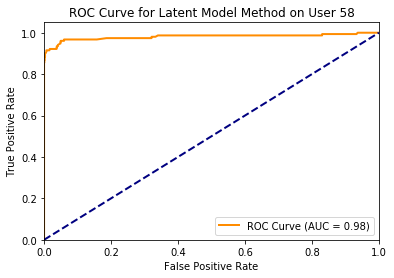

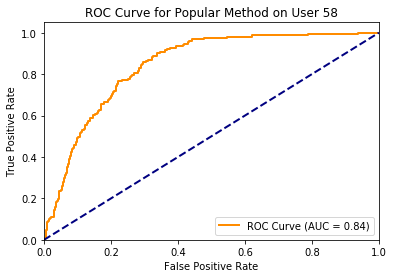

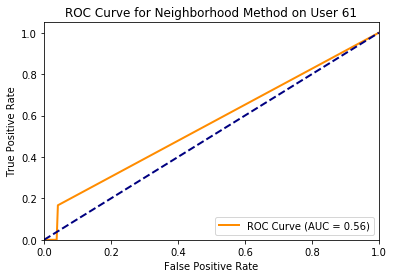

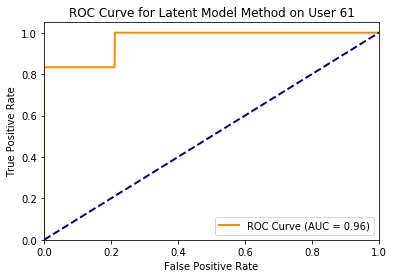

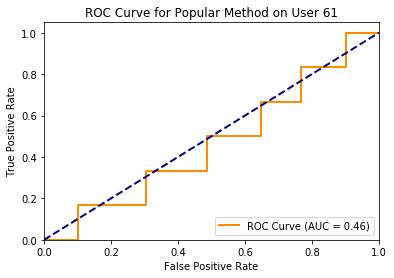

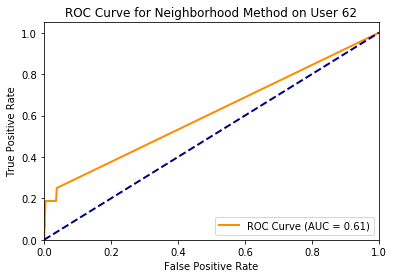

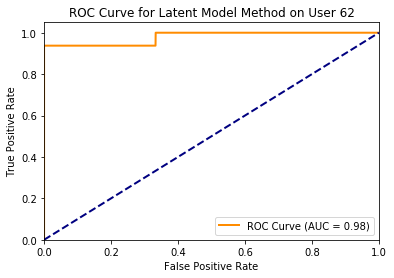

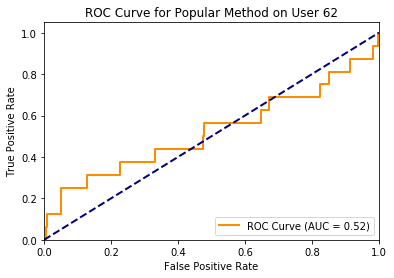

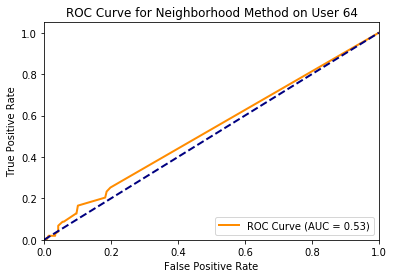

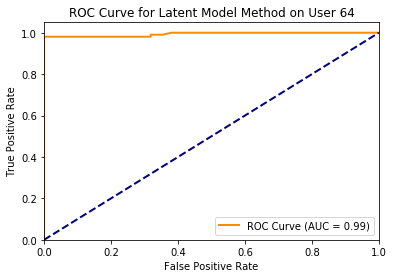

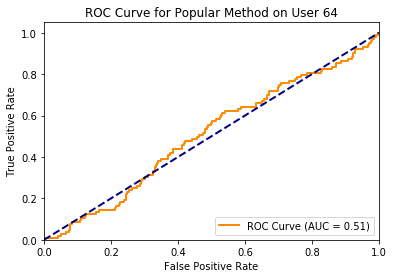

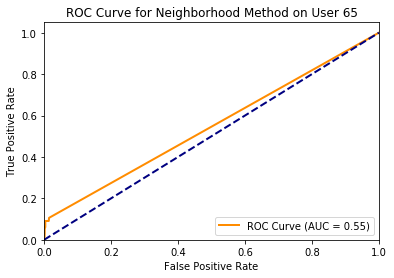

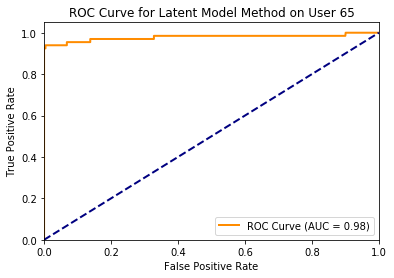

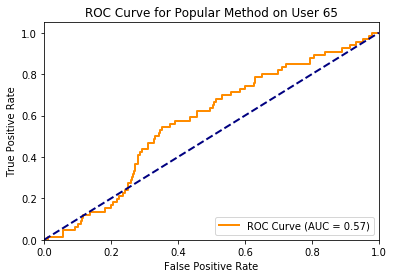

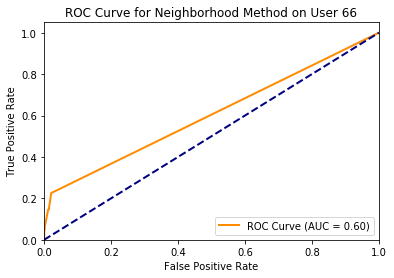

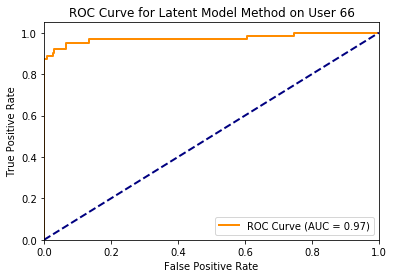

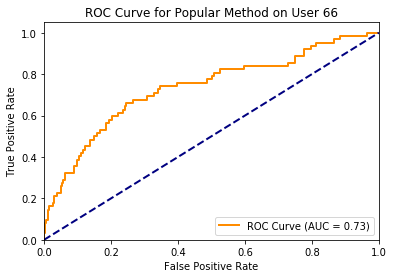

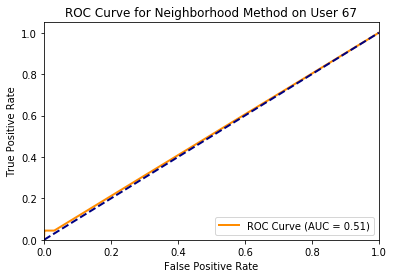

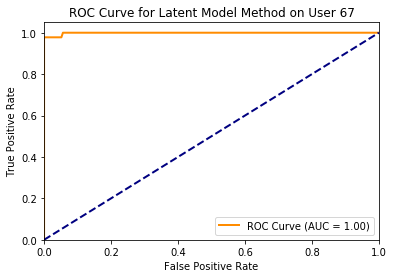

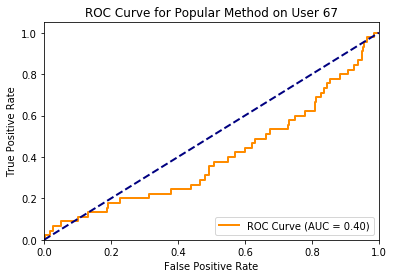

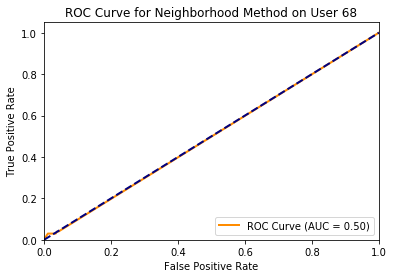

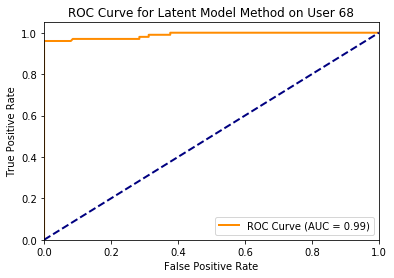

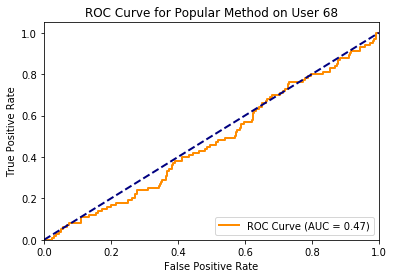

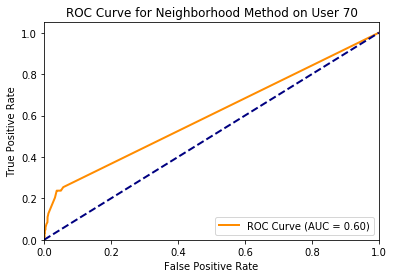

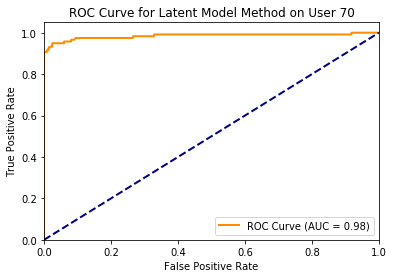

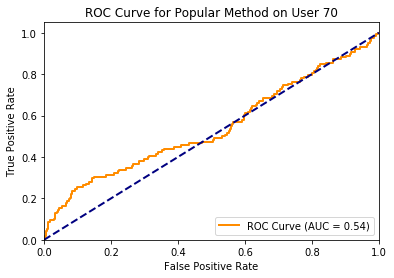

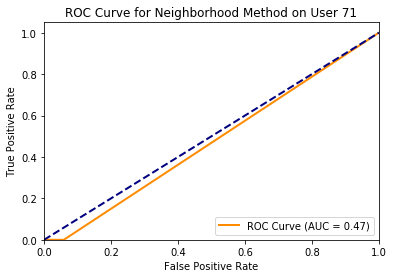

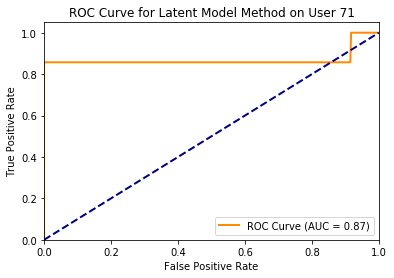

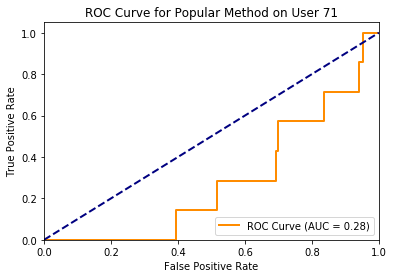

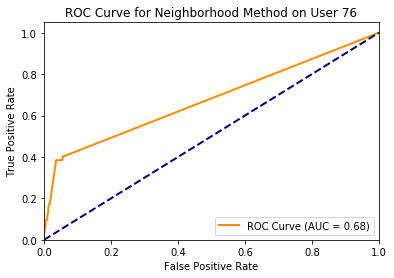

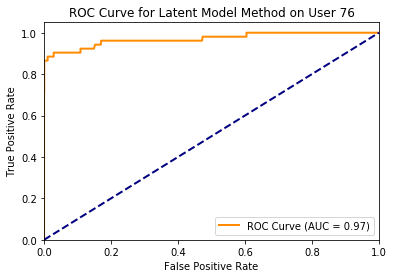

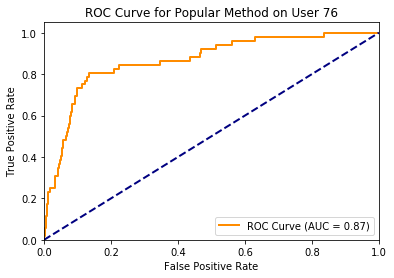

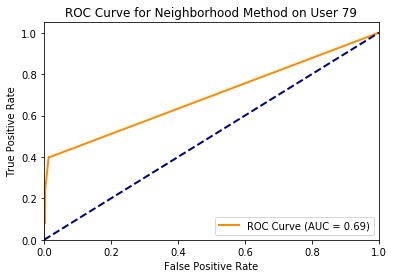

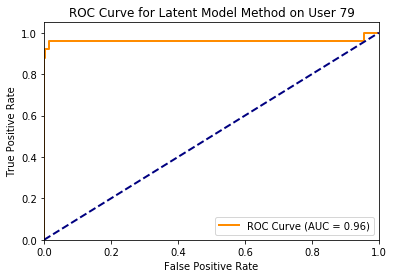

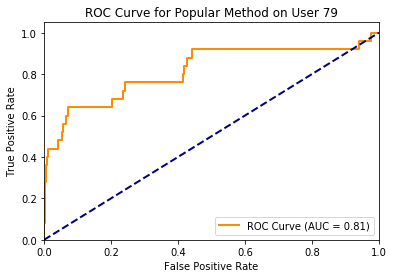

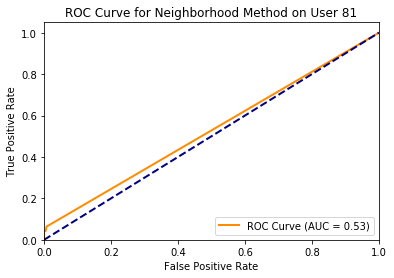

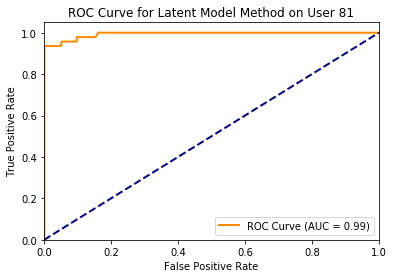

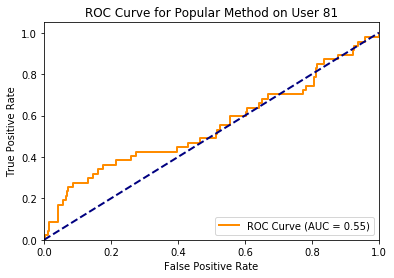

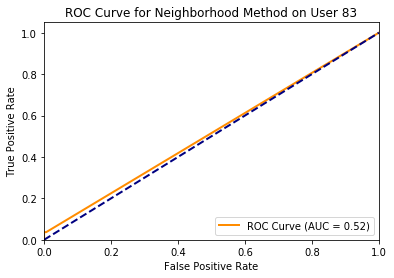

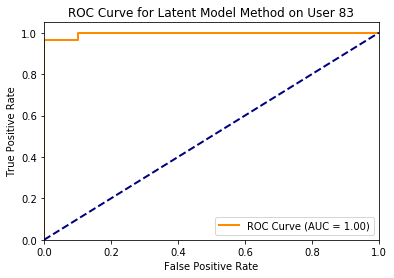

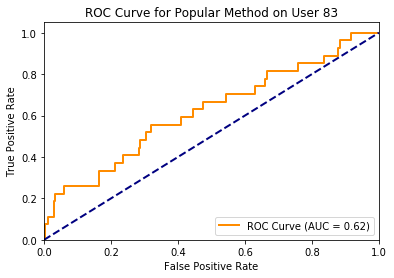

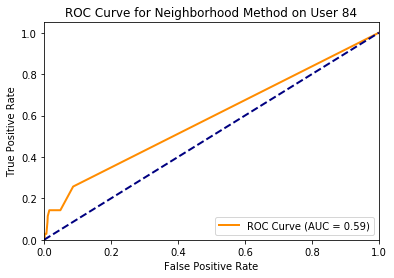

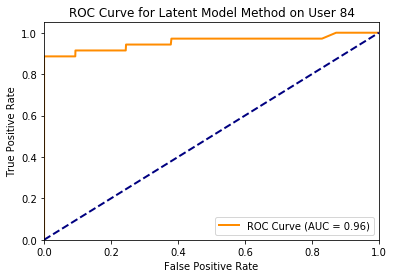

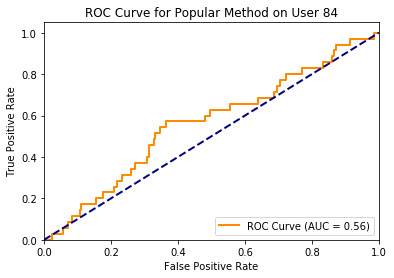

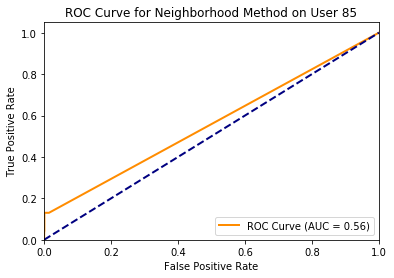

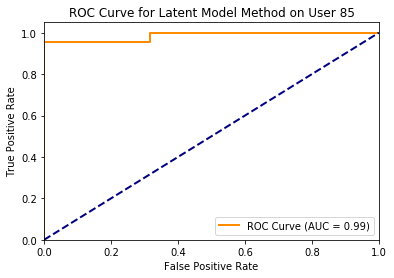

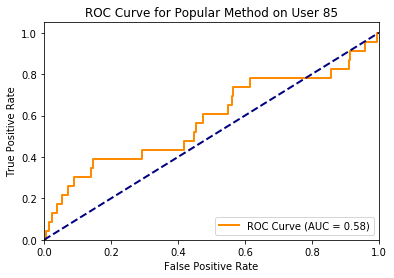

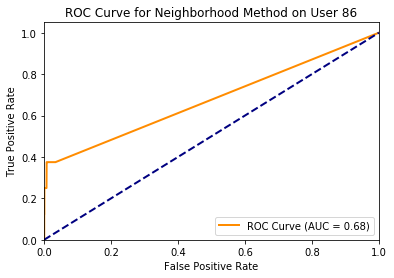

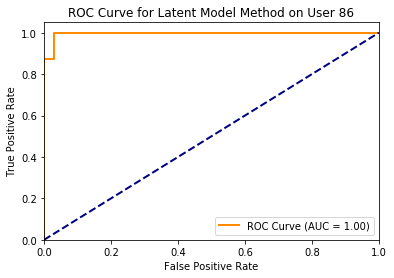

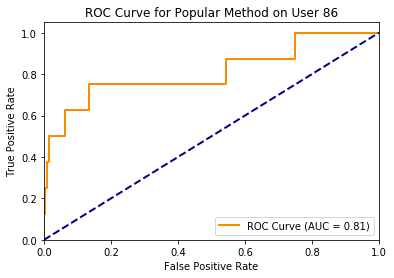

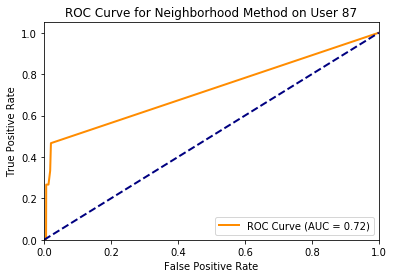

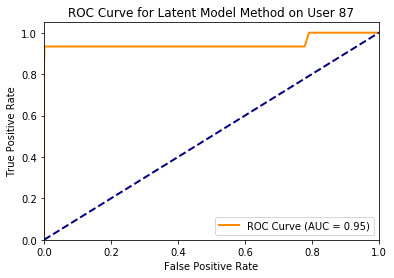

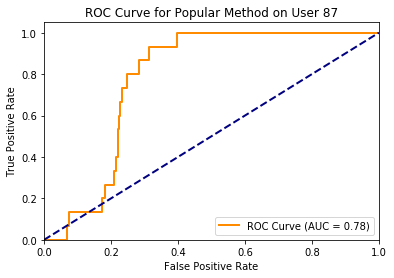

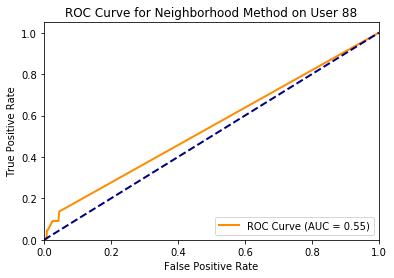

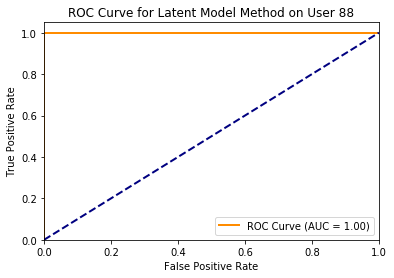

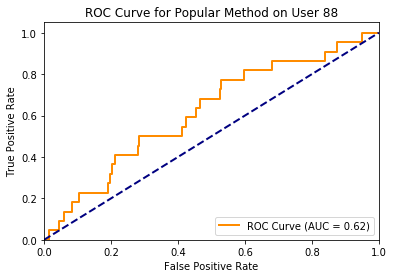

In [33]:
nn_mean_auc = mean_auc(test_pref_matrix, nn_predictions, masked_users)
latent_mean_auc = mean_auc(test_pref_matrix, latent_predictions, masked_users)
pop_mean_auc = mean_auc(test_pref_matrix, pop_predictions, masked_users)

print('Mean AUC (Neighborhood): {}'.format(nn_mean_auc))
print('Mean AUC (Latent Model): {}'.format(latent_mean_auc))
print('Mean AUC (Popular):      {}'.format(pop_mean_auc))
print('\n')

# Plot the ROC Curve for each method on each masked users
for u in masked_users:
    title = 'ROC Curve for Neighborhood Method on User {}'.format(u)
    plot_roc(test_pref_matrix[u], nn_predictions[u], title)
    title = 'ROC Curve for Latent Model Method on User {}'.format(u)
    plot_roc(test_pref_matrix[u], latent_predictions[u], title)
    title = 'ROC Curve for Popular Method on User {}'.format(u)
    plot_roc(test_pref_matrix[u], pop_predictions[u], title)

## Comparison

Which songs does each method recommend for an arbitrary user? Do they look similiar? Or completely different?

In [11]:
# Recommend k songs to a user u
def recommend(predictions, u, k):
    return np.argsort(predictions[u])[-k:]

# Print song titles using metadata
def print_items(interaction_dataframe, metadata, items, u):
    for i in items:
        song_id = interaction_dataframe.columns[i]
        row = metadata.loc[metadata['song_id'] == song_id]
        print(row['title'].iloc[0])

In [12]:
# Load metadata
metadata = pd.read_csv('song_data.csv')
metadata.drop_duplicates(['song_id'])

# Pick an arbitrary user
u = 26

# Number of recommendations to make
k = 6

# Make recommendations
nn_recommended = recommend(nn_predictions, u, k)
latent_recommended = recommend(latent_predictions, u, k)
pop_recommended = recommend(pop_predictions, u, k)

# Print recommendations
print('Songs recommended for user {} by nn:'.format(u))
print_items(interaction_dataframe, metadata, nn_recommended, u)
print('\n')

print('Songs recommended for user {} by latent model:'.format(u))
print_items(interaction_dataframe, metadata, latent_recommended, u)
print('\n')

print('Songs recommended for user {} by popular:'.format(u))
print_items(interaction_dataframe, metadata, pop_recommended, u)

Songs recommended for user 26 by nn:
Sehr kosmisch
Somebody To Love
Just Dance
Fireflies
Teach Me How To Dougie
Nobody (Featuring Athena Cage) (LP Version)


Songs recommended for user 26 by latent model:
The Real Slim Shady
My Dad's Gone Crazy
Somebody To Love
Without Me
Speechless
Ghosts 'n' Stuff (Original Instrumental Mix)


Songs recommended for user 26 by popular:
Dress Me Like a Clown
Relax
I C Love Affair
You're The One
Undo
Fools
